In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2023-04-08 11:06:04.690787: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Num GPUs Available:  1


In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train[:20%]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


In [3]:
#IMG_SIZE = 224

#ds_train = ds_train.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
#ds_test = ds_test.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
#ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


In [5]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
#ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


In [6]:
'''
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
'''
base_model = keras.applications.ResNet50(
    weights="imagenet",
    input_shape=(128,128,3),
    include_top=False
)

In [7]:
'''
testing_model = keras.applications.ResNet50(
    weights="imagenet",
    input_shape=(32,32,3),
    include_top=False
)
testing_model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)

testing_model.evaluate(ds_test)
'''


'\ntesting_model = keras.applications.ResNet50(\n    weights="imagenet",\n    input_shape=(32,32,3),\n    include_top=False\n)\ntesting_model.compile(\n    optimizer=tf.keras.optimizers.Adam(0.001),\n    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),\n    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name=\'accuracy\')],\n)\n\ntesting_model.evaluate(ds_test)\n'

In [8]:
'''
#original 
base_model.trainable = False


inputs = keras.Input(shape=(32, 32, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dense(128,activation='relu''relu')
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(10)(x)
model = keras.Model(inputs, outputs)
'''

"\n#original \nbase_model.trainable = False\n\n\ninputs = keras.Input(shape=(32, 32, 3))\n# We make sure that the base_model is running in inference mode here,\n# by passing `training=False`. This is important for fine-tuning, as you will\n# learn in a few paragraphs.\nx = base_model(inputs, training=False)\n# Convert features of shape `base_model.output_shape[1:]` to vectors\nx = keras.layers.GlobalAveragePooling2D()(x)\n#x = keras.layers.Dense(128,activation='relu''relu')\n# A Dense classifier with a single unit (binary classification)\noutputs = keras.layers.Dense(10)(x)\nmodel = keras.Model(inputs, outputs)\n"

In [9]:
#sequential 
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.UpSampling2D((2,2)))
model.add(tf.keras.layers.UpSampling2D((2,2)))
#model.add(tf.keras.layers.UpSampling2D((2,2)))
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dense(128, activation='relu'))
#model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(10,activation='softmax'))
  
  


In [10]:
#Traditional Training
#model = tf.keras.models.Sequential([
#  tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
#  tf.keras.layers.Dense(128, activation='relu'),
#  tf.keras.layers.Dense(10)
#])
earlystopping = callbacks.EarlyStopping(monitor='val_loss', 
                                        mode='min', 
                                        patience=5, 
                                        restore_best_weights=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)

model.fit(
    ds_train,
    epochs=5,
    #batch_size=512,
    validation_data=ds_test,
    callbacks =[earlystopping],
)


Epoch 1/5
79/79 [==============================] - 101s 1s/step - loss: 1.0270 - accuracy: 0.6724 - val_loss: 8.5428 - val_accuracy: 0.1000
Epoch 2/5
79/79 [==============================] - 87s 1s/step - loss: 0.4859 - accuracy: 0.8335 - val_loss: 4.2179 - val_accuracy: 0.1000
Epoch 3/5
79/79 [==============================] - 86s 1s/step - loss: 0.3038 - accuracy: 0.9017 - val_loss: 4.8787 - val_accuracy: 0.1000
Epoch 4/5
79/79 [==============================] - 66s 832ms/step - loss: 0.2407 - accuracy: 0.9188 - val_loss: 4.1112 - val_accuracy: 0.1000
Epoch 5/5
79/79 [==============================] - 73s 888ms/step - loss: 0.1924 - accuracy: 0.9353 - val_loss: 3.5733 - val_accuracy: 0.1203


In [11]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')],
)
testing = model.fit(
    ds_train,
    epochs=11,
    #batch_size=512,
    validation_data=ds_test,
    verbose=1,
    callbacks =[earlystopping],
)



Epoch 1/11


/home/sjhjrok/anaconda3/envs/ai/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


79/79 [==============================] - 75s 824ms/step - loss: 0.0719 - accuracy: 0.9790 - val_loss: 3.0110 - val_accuracy: 0.1015
Epoch 2/11
79/79 [==============================] - 87s 1s/step - loss: 0.0372 - accuracy: 0.9906 - val_loss: 2.8736 - val_accuracy: 0.1127
Epoch 3/11
79/79 [==============================] - 84s 1s/step - loss: 0.0250 - accuracy: 0.9960 - val_loss: 2.5645 - val_accuracy: 0.1851
Epoch 4/11
79/79 [==============================] - 86s 1s/step - loss: 0.0188 - accuracy: 0.9970 - val_loss: 2.0722 - val_accuracy: 0.3411
Epoch 5/11
79/79 [==============================] - 83s 940ms/step - loss: 0.0132 - accuracy: 0.9987 - val_loss: 1.5359 - val_accuracy: 0.5260
Epoch 6/11
79/79 [==============================] - 86s 1s/step - loss: 0.0107 - accuracy: 0.9994 - val_loss: 1.1212 - val_accuracy: 0.6657
Epoch 7/11
79/79 [==============================] - 69s 835ms/step - loss: 0.0092 - accuracy: 0.9996 - val_loss: 0.8343 - val_accuracy: 0.7623
Epoch 8/11
79/79 [====

<function matplotlib.pyplot.show(close=None, block=None)>

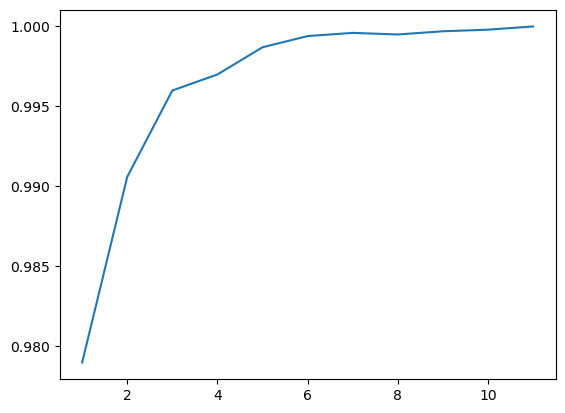

In [12]:

plt.plot(
    np.arange(1, 12), 
    testing.history['accuracy'], label='Accuracy'
)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

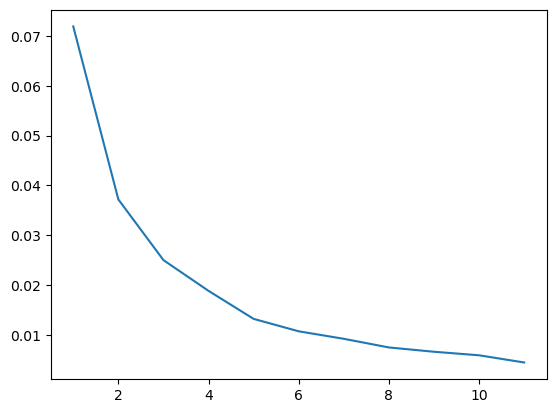

In [13]:
plt.plot(
    np.arange(1, 12), 
    testing.history['loss'], label='Loss'
)
plt.show

In [14]:
model.evaluate(ds_test)


79/79 [==============================] - 10s 132ms/step - loss: 0.5156 - accuracy: 0.8638


[0.5156154036521912, 0.8637999892234802]